In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# for reproducibility
np.random.seed(1337)

# set verbose=0 the skip the charts and other information
# set verbose=1 to see chart and other information
verbose=1

data_dir = os.path.join(os.getcwd(), 'data')

datatraining_file = os.path.join(data_dir, 'datatraining.txt')

In [2]:
train_df = pd.read_csv(datatraining_file)
train_df['date']= pd.to_datetime(train_df['date']) 

if verbose==1:
    print(train_df.shape)
    print(train_df.head(5))
    print(train_df.tail(5))
    

(8143, 7)
                 date  Temperature  Humidity  Light     CO2  HumidityRatio  \
1 2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2 2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
3 2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
4 2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
5 2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
1          1  
2          1  
3          1  
4          1  
5          1  
                    date  Temperature  Humidity  Light         CO2  \
8139 2015-02-10 09:29:00        21.05   36.0975  433.0  787.250000   
8140 2015-02-10 09:29:59        21.05   35.9950  433.0  789.500000   
8141 2015-02-10 09:30:59        21.10   36.0950  433.0  798.500000   
8142 2015-02-10 09:32:00        21.10   36.2600  433.0  820.333333   
8143 2015-02-10 09:33:00        21.10   36.2000  447.0  821.000000   

      Humi

In [3]:
train_df.sort_values(by='date', inplace=True, ascending=True)
train_df.reset_index(drop=True)

if verbose==1:
    print('Training Data:')
    print('The time series starts from: ', train_df.date.min())
    print('The time series ends on: ', train_df.date.max())
    print()


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.180000,27.272000,426.0,721.250000,0.004793,1
1,2015-02-04 17:51:59,23.150000,27.267500,429.5,714.000000,0.004783,1
2,2015-02-04 17:53:00,23.150000,27.245000,426.0,713.500000,0.004779,1
3,2015-02-04 17:54:00,23.150000,27.200000,426.0,708.250000,0.004772,1
4,2015-02-04 17:55:00,23.100000,27.200000,426.0,704.500000,0.004757,1
5,2015-02-04 17:55:59,23.100000,27.200000,419.0,701.000000,0.004757,1
6,2015-02-04 17:57:00,23.100000,27.200000,419.0,701.666667,0.004757,1
7,2015-02-04 17:57:59,23.100000,27.200000,419.0,699.000000,0.004757,1
8,2015-02-04 17:58:59,23.100000,27.200000,419.0,689.333333,0.004757,1
9,2015-02-04 18:00:00,23.075000,27.175000,419.0,688.000000,0.004745,1


Training Data:
The time series starts from:  2015-02-04 17:51:00
The time series ends on:  2015-02-10 09:33:00



In [4]:
if verbose==1:
    print('Columns having ZERO values:')
    print(train_df.eq(0).sum())
    print()

# Light has 5160 zero values - no issue since the light was switched off when there was no occupacy
# Occupancy has 6414 zero values - no issue since '0' represents unoccupied

Columns having ZERO values:
date                0
Temperature         0
Humidity            0
Light            5160
CO2                 0
HumidityRatio       0
Occupancy        6414
dtype: int64



In [5]:
def chart(f, df, c):
    fig, axes = plt.subplots(nrows=len(f), figsize=(10, 10))
    for i in range(0, len(f.values)):
        axes[i].plot(df['date'], df[f.values[i]], color=c)
        axes[i].set_title(f.values[i])
        axes[i].grid(True)
    plt.subplots_adjust(hspace=0.8, )
    plt.show()


C:\Users\SengTian\Anaconda3\envs\tf1.15\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


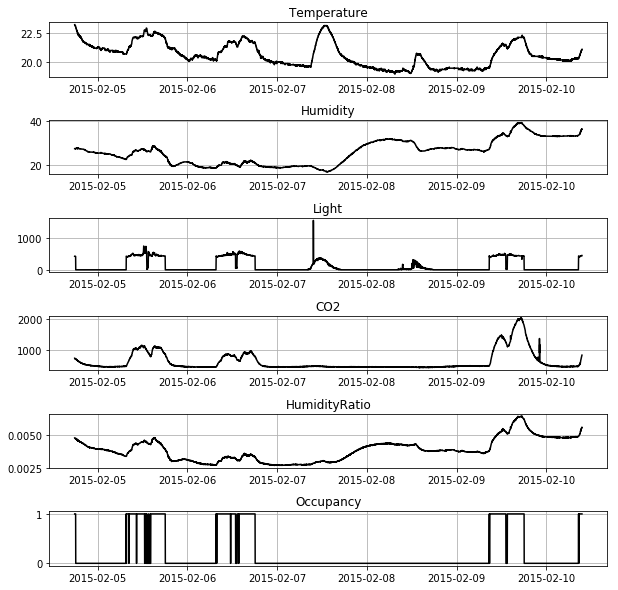

In [6]:
if verbose==1:
    chart(train_df.columns[1:], train_df, 'black')
    

In [7]:
X = train_df.loc[:, 'Temperature' : 'HumidityRatio'].copy().to_numpy()
y = train_df.loc[:, 'Occupancy'].copy().to_numpy()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#reshape for LSTM 6514 samples, 1 timestep and 5 features
X_train = X_train.reshape(-1, 1, 5)
X_test = X_test.reshape(-1, 1, 5)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

network.summary()


Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                4320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = network.fit(X_train, y_train, epochs=15, batch_size=50, verbose=1, shuffle=True, validation_data=(X_test, y_test))

print()
test_loss, test_acc = network.evaluate (X_test, y_test)
print('test_acc:', test_acc)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6514 samples, validate on 1629 samples
Epoch 1/15





6514/6514 [==============================] - 3s 516us/step - loss: 0.2101 - acc: 0.7857 - val_loss: 0.1744 - val_acc: 0.7876
Epoch 2/15
6514/6514 [==============================] - 1s 180us/step - loss: 0.1441 - acc: 0.7944 - val_loss: 0.1074 - val_acc: 0.8324
Epoch 3/15
6514/6514 [==============================] - 1s 172us/step - loss: 0.0819 - acc: 0.9193 - val_loss: 0.0562 - val_acc: 0.9564
Epoch 4/15
6514/6514 [==============================] - 1s 174us/step - loss: 0.0508 - acc: 0.9549 - val_loss: 0.0394 - val_acc: 0.9626
Epoch 5/15
6514/6514 [==============================] - 1s 203us/step - loss: 0.0395 - acc: 0.9598 - val_loss: 0.0315 - val_acc: 0.9662
Epoch 6/15
6514/6514 [==============================] - 1s 215us/step - loss: 0.0331 - acc: 0.9659 - val_loss: 0.0261 - val_acc: 0.9718
Epoch 7/15
6514/6514 [============

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

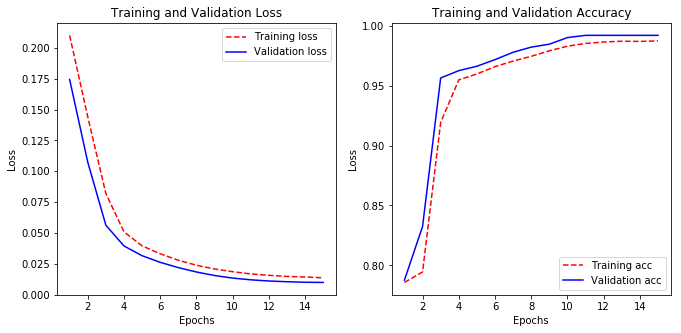

In [12]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#draw a chart to show validation vs training losses
ax1.plot(epochs, loss_values, 'r--', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.title.set_text('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# draw a chart to show validation vs training accuracy
ax2.plot(epochs, acc_values, 'r--', label='Training acc')
ax2.plot(epochs, val_acc_values, 'b', label='Validation acc')
ax2.title.set_text('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()
